# A1 - More fluctuation leads to more generalist
(re-running with no-recovery model)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
# from functions_deutsch_tpc import *
from tpc_functions_oo import *
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import tskit
import pandas as pd
import os
import itertools
from matplotlib import cm
import matplotlib as mpl
import random
from matplotlib.patches import Ellipse
from matplotlib.lines import Line2D
import matplotlib.transforms as transforms
from scipy.signal import lfilter
datadir = "/projects/lotterhos/TPC_sim_results/data/"
if os.path.isdir(datadir):
    print("working on cluster")
else:
    print("working on local machine")
    datadir = "../SLiM_scripts/data/"

viridis_cmap = plt.get_cmap('viridis')
managua_cmap = plt.get_cmap('managua')

plt.rcParams.update({'font.size': 15})

working on cluster


In [2]:
# Set up confidence ellipse for later
def confidence_ellipse(x_std, y_std, xy_cov, mean_x, mean_y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x_std : standard deviation of x
    y_std : standard deviation of y
    xy_cov : covariance between x and y
    mean_x : mean of x
    mean_y : mean of y
    ax : matplotlib.axes.Axes
        The Axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    pearson = xy_cov / (x_std * y_std)
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(x_std * n_std, y_std * n_std) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [3]:
# Function for finding equilibration time.
# We fine when fitness has gotten 99% close to the final value for the first time, using the smoothed out fitness curve. 
# Because SLiM logs every 10 generation, round up the t equilibration to multiples of 10.
def fit_t_equil(row):
    log = pd.read_csv(f"{datadir}{row.OUTNAME}.txt", sep=',')
    log = log.loc[log.cycle > 5000].reset_index(drop=True)
    try:
        
        if log.cycle.iloc[-1] > row.RUNTIME:
            # Smooth the mean fitness curve, find where the smoothed fitness becomes 99% close to the final fitness value
            n = 10             # larger n gives smoother curves
            b = [1.0 / n] * n  # numerator coefficients
            a = 1              # denominator coefficient
            y_lf = lfilter(b, a, np.array(log.fitness_mean))
            t_equil = None
            for index2, row2 in log.iterrows():
                if (y_lf[index2] - y_lf[0] > 0.99 * (y_lf[-1] - y_lf[0])) and (t_equil == None):
                    t_equil = row2.cycle
                    t_equil = round(t_equil, -1)
            
            fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
            ax.plot(log.cycle, log.fitness_mean)
            ax.vlines(t_equil, ymin=log.fitness_mean.min(), ymax=log.fitness_mean.max())
            ax.set_xlabel("generation")
            ax.set_ylabel("fitness")
            fig.savefig(f"{datadir}t_equil_{row.OUTNAME}.png")
            plt.close()
            return t_equil

    except IndexError:
        print("log file empty")


## 0. Load parameter data, find equilibration time


In [4]:
params = pd.read_csv(f"{datadir}A1_nr_params.csv")
print(params.head())
tpc_object = w_TPC()

   run_id  muT  sigmaT  seed     N  RUNTIME  B_WT  CTmin_WT  \
0       0    5       1     0  5000    20000    31         5   
1       1    5       1     1  5000    20000    31         5   
2       2    5       1     2  5000    20000    31         5   
3       3    5       1     3  5000    20000    31         5   
4       4    5       1     4  5000    20000    31         5   

                       OUTNAME  
0  A1_nr_muT_5_sigmaT_1_seed_0  
1  A1_nr_muT_5_sigmaT_1_seed_1  
2  A1_nr_muT_5_sigmaT_1_seed_2  
3  A1_nr_muT_5_sigmaT_1_seed_3  
4  A1_nr_muT_5_sigmaT_1_seed_4  


In [6]:

# Attach the equilibrium time to the params dataframe
params['t_equil'] = params.apply(fit_t_equil, axis=1)
print(params['t_equil'])
# save the params dataframe (that has equilibrium times as the last column) as another csv file.
params.to_csv(f"{datadir}A1_nr_params_t_equil_attached.csv")

0      6030.0
1      6330.0
2      6270.0
3      5900.0
4      5730.0
        ...  
265    5640.0
266    5470.0
267    5770.0
268    5850.0
269    5910.0
Name: t_equil, Length: 270, dtype: float64


In [7]:
t_equil_df = params.groupby(['muT', 'sigmaT', 'B_WT', 'CTmin_WT']).agg({
    't_equil': ['mean', 'std']
}).round(-1)
print(t_equil_df['t_equil'])


                             mean     std
muT sigmaT B_WT CTmin_WT                 
5   1      31   5          6010.0   180.0
    3      31   5          5730.0   180.0
    10     31   5          5540.0   150.0
20  1      31   5          6030.0   180.0
    3      31   5          5590.0   120.0
    10     31   5          5660.0   210.0
35  1      31   5         16280.0  1150.0
    3      31   5         25040.0  4410.0
    10     31   5          5740.0   260.0


In [8]:
params_si = pd.read_csv(f"{datadir}A1S1_nr_params.csv")
params_si['t_equil'] = params_si.apply(fit_t_equil, axis=1)
params_si.to_csv(f"{datadir}A1S1_nr_params_t_equil_attached.csv")


In [9]:
t_equil_df = params_si.groupby(['muT', 'sigmaT', 'B_WT', 'CTmin_WT']).agg({
    't_equil': ['mean', 'std']
}).round(-1)
print(t_equil_df['t_equil'])

                             mean     std
muT sigmaT B_WT CTmin_WT                 
5   1      5    33         6180.0   310.0
    3      5    33         8840.0  1340.0
    10     5    33         6290.0   120.0
20  1      5    33         7040.0   310.0
    3      5    33         6540.0   140.0
    10     5    33         7100.0   180.0
35  1      5    33         5810.0   190.0
    3      5    33         7600.0  1280.0
    10     5    33        14300.0  1610.0


## 1. Final TPCs
- Increasing mean temperature (i.e. going from top to bottom), TPCs move to higher temperature. 

- Increasing standard deviation of temperature (i.e. going from left to right), TPCs become more generalist.

- Topt (peak of TPC) tends to increase as standard deivation increases (left to right), except for T = 35 (bottom row). This is because of the relatively strong constraint for heat adaptation. (i.e. limit to how high CTmax can go up)


In [10]:
# Classify final TPCs into red (blue, or green) if CTmax (CTmin, or B) is close to critical value.

def classify_final_TPCs(row):
    # threshold w_component when parameter = parameter_critical + Delta_parameter (replace parameter with CTmin, CTmax or B)
    threshold = scipy.special.expit(1) 
    ts = tskit.load(f"{datadir}{row.OUTNAME}.trees")
    metadata = ts.metadata['SLiM']['user_metadata']
    Bs_final_new = np.array(metadata['Bs_final'])
    CTmins_final_new = np.array(metadata['CTmins_final'])

    n_green = 0
    n_blue = 0
    n_red = 0
    n_grey = 0
    n_others = 0
    for B, CTmin in zip(Bs_final_new, CTmins_final_new):
        w_CTmin = tpc_object.w_CTmin(CTmin=CTmin)
        w_B = tpc_object.w_B(B=B)
        CTmax = CTmin + B
        w_CTmax = tpc_object.w_CTmax(CTmax=CTmax)
        if (w_B < threshold) and (w_CTmin > threshold) and (w_CTmax > threshold):
            # Too generalist
            n_green += 1
        elif (w_CTmin < threshold) and (w_B > threshold) and (w_CTmax > threshold):
            # Too much cold adaptation
            n_blue += 1
        elif (w_B > threshold) and (w_CTmin > threshold) and (w_CTmax < threshold):
            # Too much heat adaptation
            n_red += 1
        elif (np.array([w_B, w_CTmin, w_CTmax]) > threshold).all():
            # not limited by any of 3 physiological constraints
            n_grey += 1
        else:
            # too much adaptation for two different parameters
            n_others += 1
    n_total = n_green + n_blue + n_red + n_grey + n_others
    ratio_green = n_green / n_total
    ratio_blue = n_blue / n_total
    ratio_red = n_red / n_total
    ratio_grey = n_grey / n_total
    ratio_others = n_others / n_total
    return (row.muT, row.sigmaT, row.seed, ratio_green, ratio_blue, ratio_red, ratio_grey, ratio_others)

final_tpc_classified_df = params.apply(classify_final_TPCs, axis=1, result_type='expand')
final_tpc_classified_df.columns = ['mean_T', 'std_T', 'seed', 'ratio_green', 'ratio_blue', 'ratio_red', 'ratio_grey', 'ratio_others']
print(final_tpc_classified_df.head())

   mean_T  std_T  seed  ratio_green  ratio_blue  ratio_red  ratio_grey  \
0     5.0    1.0   0.0          0.0      0.7896        0.0      0.2104   
1     5.0    1.0   1.0          0.0      0.7982        0.0      0.2018   
2     5.0    1.0   2.0          0.0      0.7792        0.0      0.2208   
3     5.0    1.0   3.0          0.0      0.7954        0.0      0.2046   
4     5.0    1.0   4.0          0.0      0.7808        0.0      0.2192   

   ratio_others  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  


In [11]:
summary_df = final_tpc_classified_df.groupby(['mean_T', 'std_T']).agg({
    'ratio_green': ['mean', 'std'],
    'ratio_blue': ['mean', 'std'],
    'ratio_red': ['mean', 'std'],
    'ratio_grey': ['mean', 'std'],
    'ratio_others': ['mean', 'std']
})
print("ratio of blue TPCs out of all TPCs:")
print(summary_df['ratio_blue'])

print("\n ratio of red TPCs out of all TPCs:")
print(summary_df['ratio_red'])

ratio of blue TPCs out of all TPCs:
                  mean       std
mean_T std_T                    
5.0    1.0    0.787120  0.013627
       3.0    0.762400  0.017359
       10.0   0.060287  0.008715
20.0   1.0    0.000000  0.000000
       3.0    0.000007  0.000037
       10.0   0.000013  0.000051
35.0   1.0    0.000000  0.000000
       3.0    0.000000  0.000000
       10.0   0.000000  0.000000

 ratio of red TPCs out of all TPCs:
                  mean       std
mean_T std_T                    
5.0    1.0    0.000000  0.000000
       3.0    0.000000  0.000000
       10.0   0.000000  0.000000
20.0   1.0    0.000000  0.000000
       3.0    0.000000  0.000000
       10.0   0.014860  0.002325
35.0   1.0    0.080700  0.005884
       3.0    0.173713  0.006343
       10.0   0.081793  0.006035


muT=5, sigmaT=1
muT=5, sigmaT=3
muT=5, sigmaT=10
muT=20, sigmaT=1
muT=20, sigmaT=3
muT=20, sigmaT=10
muT=35, sigmaT=1
muT=35, sigmaT=3
muT=35, sigmaT=10


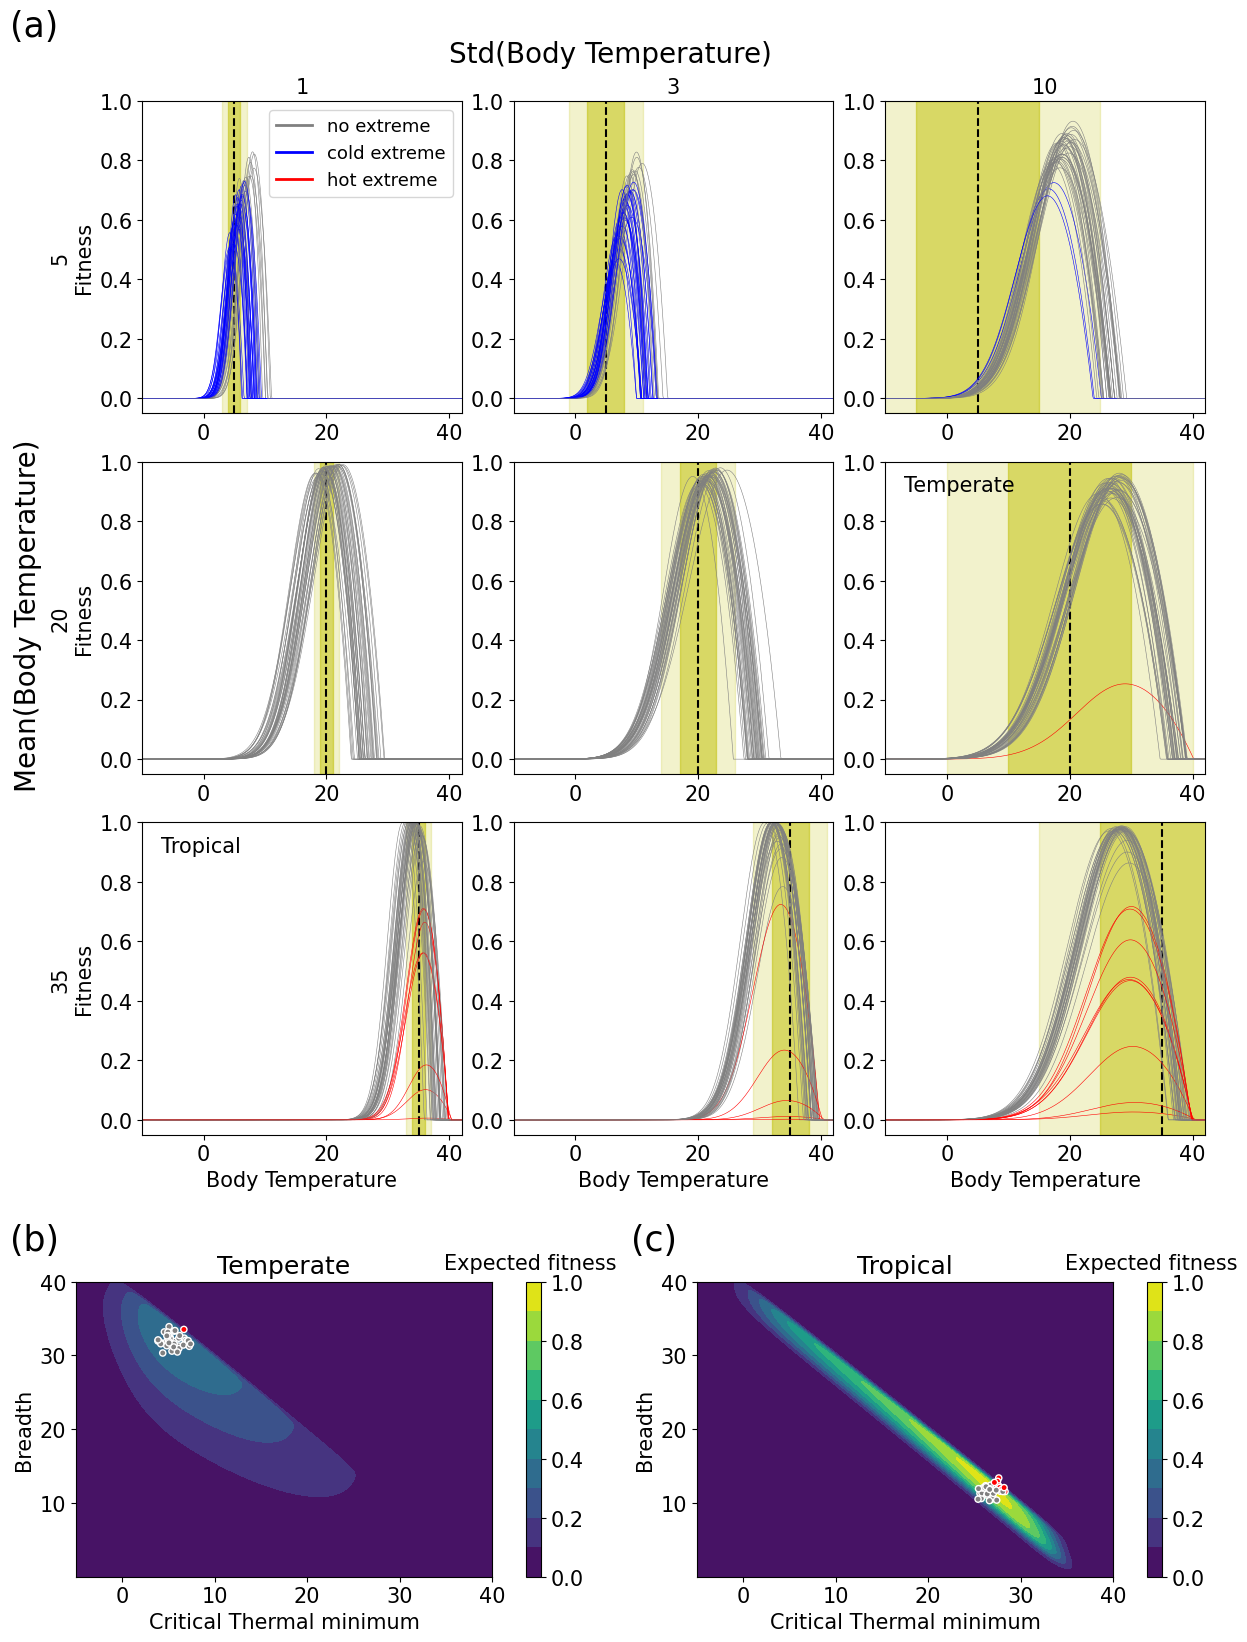

In [22]:
muTs = params.muT.unique()
sigmaTs = params.sigmaT.unique()
fig = plt.figure(layout='constrained', figsize=(12, 16))
subfigs = fig.subfigures(2, 1, hspace = 0.07, height_ratios=[3,1])
subsubfigs = subfigs[1].subfigures(1, 2, wspace=0.07, width_ratios=[1,1])
subfigs[0].text(0, 1, "(a)", fontsize=25)
subsubfigs[0].text(0, 1, "(b)", fontsize=25)
subsubfigs[1].text(0, 1, "(c)", fontsize=25)

ax_top = subfigs[0].subplots(nrows = len(muTs), ncols = len(sigmaTs))
T_series = np.linspace(-10, 42, 500)

threshold = scipy.special.expit(1) # threshold for coloring - when the parameter is within critical value plus/minus Delta_parameter
for i, muT in enumerate(muTs):
    for j, sigmaT in enumerate(sigmaTs):
        print(f"muT={muT}, sigmaT={sigmaT}")
        ax_top[i, j].vlines(muT, ymin=-0.05, ymax=1.05, linestyle='--', color='k')
        ax_top[i, j].axvspan(muT-2*sigmaT, muT+2*sigmaT, color='y', alpha=0.2)
        ax_top[i, j].axvspan(muT-sigmaT, muT+sigmaT, color='y', alpha=0.5)
        ax_top[i, j].set_ylim((-0.05, 1))
        ax_top[i, j].set_xlim((min(T_series), max(T_series)))
        if i == 0:
            ax_top[i, j].set_title(f"{sigmaT}", fontsize=15)
        if j == 0:
            ax_top[i,j].set_ylabel(f"{muT}\nFitness", fontsize=15)
        if i == len(muTs)-1:
            ax_top[i,j].set_xlabel("Body Temperature", fontsize=15)
        subfigs[0].suptitle("Std(Body Temperature)", fontsize=20)
        subfigs[0].supylabel("Mean(Body Temperature)", fontsize=20)
tropical_Bs= []
tropical_CTmins = []
tropical_colors = []
temperate_Bs = []
temperate_CTmins = []
temperate_colors = []

for index, row in params.iterrows():
    # locate muT and sigmaT in the unique list
    if row.seed != 29:
        continue
    i = list(muTs).index(row.muT)
    j = list(sigmaTs).index(row.sigmaT)
    ts = tskit.load(f"{datadir}{row.OUTNAME}.trees")
    metadata = ts.metadata['SLiM']['user_metadata']
    Bs_final_new = np.array(metadata['Bs_final'])
    CTmins_final_new = np.array(metadata['CTmins_final'])
    random.seed(10)
    sample_idx = random.sample(range(len(Bs_final_new)), 40)
    for B, CTmin in zip(Bs_final_new[sample_idx], CTmins_final_new[sample_idx]):
        w_CTmin = tpc_object.w_CTmin(CTmin)
        w_B = tpc_object.w_B(B)
        CTmax = CTmin + B
        w_CTmax = tpc_object.w_CTmax(CTmax)
        if (w_B < threshold) and (w_CTmin > threshold) and (w_CTmax > threshold):
            # Too generalist
            color = 'g'
            alpha = 1
        elif (w_CTmin < threshold) and (w_B > threshold) and (w_CTmax > threshold):
            # Too much cold adaptation
            color = 'b'
            alpha = 1
        elif (w_B > threshold) and (w_CTmin > threshold) and (w_CTmax < threshold):
            # Too much heat adaptation
            color = 'r'
            alpha = 1
        elif (np.array([w_B, w_CTmin, w_CTmax]) > threshold).all():
            # not limited by any of 3 physiological constraints
            color = 'grey'
            alpha = 1
        else:
            print("constrained by more than one types of limits")
            continue
        ax_top[i, j].plot(T_series, tpc_object.w_TPC(CTmin=CTmin, B=B, T=T_series), 
                      linewidth=0.4, 
                      alpha=alpha, 
                      color=color)
        # save B, CTmin and color for subfigure (B) and (C) if temperate or tropic
        if i == 1 and j == 2:
            temperate_Bs.append(B)
            temperate_CTmins.append(CTmin)
            temperate_colors.append(color)
        elif i == 2 and j == 0:
            tropical_Bs.append(B)
            tropical_CTmins.append(CTmin)
            tropical_colors.append(color)
            

# Label "tropical" and "temperate"
ax_top[2, 0].text(-7, 0.9, "Tropical")
ax_top[1, 2].text(-7, 0.9, "Temperate")
# Create custom legend handles
legend_handles = [
    Line2D([0], [0], color='grey', linewidth=2, label='no extreme'),
    Line2D([0], [0], color='blue', linewidth=2, label='cold extreme'),
    Line2D([0], [0], color='red', linewidth=2, label='hot extreme'),
]

# Add the legend to the figure (first subplot)
ax_top[0,0].legend(handles=legend_handles, fontsize=13)

# Subfigure 2: fitness landscape for tropical vs. temperate
ax_bottom_left = subsubfigs[0].subplots(nrows=1, ncols = 1)
analytical_info = np.load(f"{datadir}A1_nr_muT_20_sigmaT_10_analytical_info.npz", allow_pickle=True)

contour = ax_bottom_left.contourf(analytical_info['CTmin_grid'], 
                                  analytical_info['B_grid'], 
                                  analytical_info['W_contour'], 
                                  levels=np.linspace(0, 1, 11), 
                                  cmap='viridis')


ax_bottom_left.set_xlabel("Critical Thermal minimum")
ax_bottom_left.set_ylabel("Breadth")
ax_bottom_left.set_title("Temperate")
fig.colorbar(contour, ax=ax_bottom_left)
subsubfigs[0].text(0.75, 0.95, "Expected fitness")
ax_bottom_left.scatter(temperate_CTmins, temperate_Bs, marker='o', edgecolor='w', facecolor=temperate_colors, s=20)

# Todo - scatter plot the inviduals. (Also colored grey, blue or red)
ax_bottom_right = subsubfigs[1].subplots(nrows=1, ncols = 1)

analytical_info = np.load(f"{datadir}A1_nr_muT_35_sigmaT_1_analytical_info.npz", allow_pickle=True)

contour = ax_bottom_right.contourf(analytical_info['CTmin_grid'], 
                                  analytical_info['B_grid'], 
                                  analytical_info['W_contour'], 
                                  levels=np.linspace(0, 1, 11), 
                                  cmap='viridis')
ax_bottom_right.set_xlabel("Critical Thermal minimum")
ax_bottom_right.set_ylabel("Breadth")
ax_bottom_right.set_title("Tropical")
subsubfigs[1].text(0.75, 0.95, "Expected fitness")
fig.colorbar(contour, ax=ax_bottom_right)
ax_bottom_right.scatter(tropical_CTmins, tropical_Bs, marker='o', edgecolor='w', facecolor=tropical_colors, s=20)

fig.savefig(f"{datadir}result-a1-tpc-samples.png")
fig.savefig(f"{datadir}result-a1-tpc-samples.pdf", bbox_inches='tight')

## 2. TPC parameter trajectory and fitness landscape

We now plot the TPC parameters, CTmin and B, on top of the expected fitness landscape. The concentric ellipses indicate where CTmin and B are one or two standard deivations way from the population mean. In each plot, we draw the CTmin and B distribution right after the burn-in period until the end of simulation (20k generations). The red dash line marks the numerical solution to the differantial equation describing the theoretical trajectory of (CTmin, B). Star marks where the fitness is maximized.

muT=5, sigmaT=1
muT=5, sigmaT=3
muT=5, sigmaT=10
muT=20, sigmaT=1
muT=20, sigmaT=3
muT=20, sigmaT=10
muT=35, sigmaT=1
muT=35, sigmaT=3
muT=35, sigmaT=10


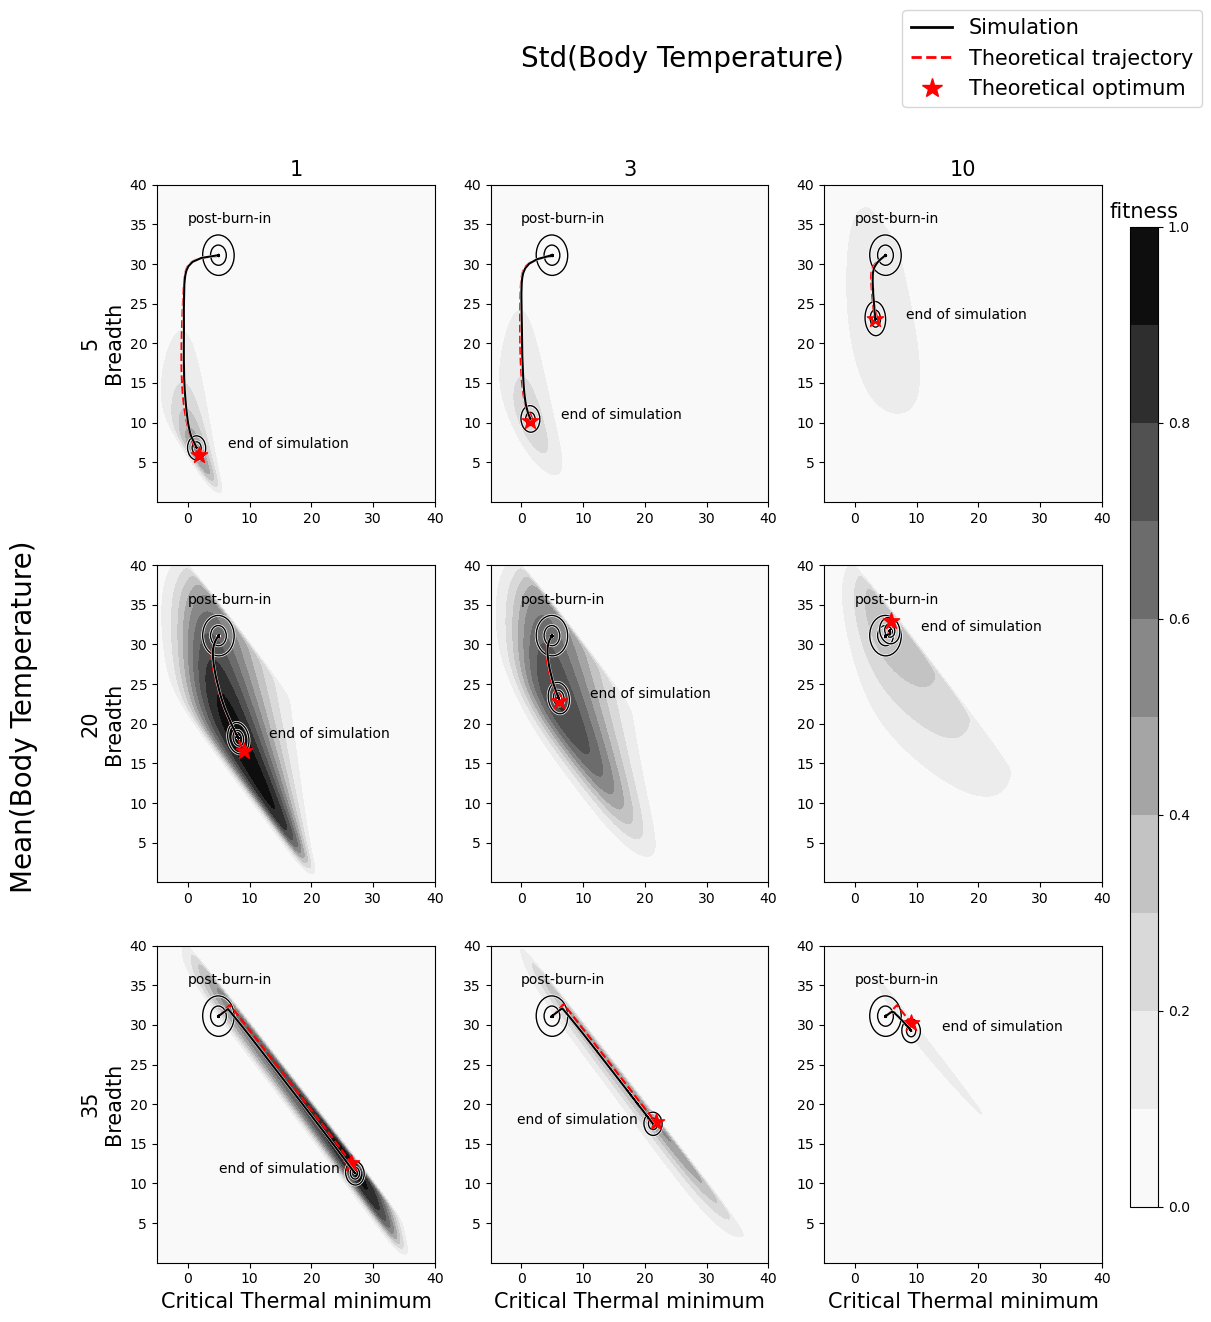

In [17]:

params_unique = pd.read_csv(f"{datadir}A1_nr_params_unique.csv")
muTs = params_unique.muT.unique()
sigmaTs = params_unique.sigmaT.unique()
# index for burn-in timing
t_0=500
fig, ax = plt.subplots(nrows = len(muTs), ncols = len(sigmaTs), figsize=(14, 14))       
# Store min and max cycle values for colorbar
all_cycle_values = []
contour_plot = None  # Store one contour plot for the colorbar
fig.supylabel("Mean(Body Temperature)", fontsize=20)
fig.suptitle("Std(Body Temperature)", fontsize=20)

for i, (muT, sigmaT) in enumerate(itertools.product(muTs, sigmaTs)):
    j = list(muTs).index(muT)
    k = list(sigmaTs).index(sigmaT)
    if sigmaT < 3:
        ax.flat[i].set_ylabel(f"{muT}\nBreadth", fontsize=15)
    if muT > 34:
        ax.flat[i].set_xlabel(f"Critical Thermal minimum", fontsize=15)
    elif muT < 10:
        ax.flat[i].set_title(f"{sigmaT}", fontsize=15)
    print(f"muT={muT}, sigmaT={sigmaT}")
    params_unique_subset = params_unique[params_unique.sigmaT > 0].reset_index()
    outname = params_unique_subset.loc[i, 'OUTNAME']
    avg_df = np.load(f"{datadir}avg_df_{outname}.npy", allow_pickle=True).item()
    analytical_info = np.load(f"{datadir}{outname}_analytical_info.npz", allow_pickle=True)
    
    contour = ax.flat[i].contourf(analytical_info['CTmin_grid'], 
                                  analytical_info['B_grid'], 
                                  analytical_info['W_contour'], 
                                  levels=np.linspace(0, 1, 11), 
                                  cmap='Greys')
    
    # Store the first contour plot for colorbar reference
    if contour_plot is None:
        contour_plot = contour
    
    ax.flat[i].plot(analytical_info['sol'].item().y[0], analytical_info['sol'].item().y[1], linestyle='--', color='r')
    # plot confidence ellipse for right after burnin period
    confidence_ellipse(avg_df['sd(CTmin)'][t_0], 
                       avg_df['sd(B)'][t_0], 
                       avg_df['cov(B, CTmin)'][t_0], 
                       avg_df['mean(CTmin)'][t_0], 
                       avg_df['mean(B)'][t_0],
                       ax.flat[i], 
                       n_std=1.0, 
                       edgecolor='white',
                       linewidth = 2
                      )
    confidence_ellipse(avg_df['sd(CTmin)'][t_0], 
                       avg_df['sd(B)'][t_0], 
                       avg_df['cov(B, CTmin)'][t_0], 
                       avg_df['mean(CTmin)'][t_0], 
                       avg_df['mean(B)'][t_0],
                       ax.flat[i], 
                       n_std=2.0, 
                       edgecolor='white',
                       linewidth=2
                      )

    confidence_ellipse(avg_df['sd(CTmin)'][t_0], 
                       avg_df['sd(B)'][t_0], 
                       avg_df['cov(B, CTmin)'][t_0], 
                       avg_df['mean(CTmin)'][t_0], 
                       avg_df['mean(B)'][t_0],
                       ax.flat[i], 
                       n_std=1.0, 
                       edgecolor='black', 
                      )
    confidence_ellipse(avg_df['sd(CTmin)'][t_0], 
                       avg_df['sd(B)'][t_0], 
                       avg_df['cov(B, CTmin)'][t_0], 
                       avg_df['mean(CTmin)'][t_0], 
                       avg_df['mean(B)'][t_0],
                       ax.flat[i], 
                       n_std=2.0, 
                       edgecolor='black', 
                      )
    # plot confidence ellipse at the end
    confidence_ellipse(avg_df['sd(CTmin)'][-1], 
                       avg_df['sd(B)'][-1], 
                       avg_df['cov(B, CTmin)'][-1], 
                       avg_df['mean(CTmin)'][-1], 
                       avg_df['mean(B)'][-1],
                       ax.flat[i], 
                       n_std=1.0, 
                       edgecolor='white',
                       linewidth=2
                      )
    confidence_ellipse(avg_df['sd(CTmin)'][-1], 
                       avg_df['sd(B)'][-1], 
                       avg_df['cov(B, CTmin)'][-1], 
                       avg_df['mean(CTmin)'][-1], 
                       avg_df['mean(B)'][-1],
                       ax.flat[i], 
                       n_std=2.0, 
                       edgecolor='white', 
                       linewidth=2
                      )

    
    # plot confidence ellipse at the end
    confidence_ellipse(avg_df['sd(CTmin)'][-1], 
                       avg_df['sd(B)'][-1], 
                       avg_df['cov(B, CTmin)'][-1], 
                       avg_df['mean(CTmin)'][-1], 
                       avg_df['mean(B)'][-1],
                       ax.flat[i], 
                       n_std=1.0, 
                       edgecolor='k', 
                      )
    confidence_ellipse(avg_df['sd(CTmin)'][-1], 
                       avg_df['sd(B)'][-1], 
                       avg_df['cov(B, CTmin)'][-1], 
                       avg_df['mean(CTmin)'][-1], 
                       avg_df['mean(B)'][-1],
                       ax.flat[i], 
                       n_std=2.0, 
                       edgecolor='k', 
                      )
    ax.flat[i].plot(avg_df['mean(CTmin)'], avg_df['mean(B)'], color = 'w', linewidth=2)
    ax.flat[i].plot(avg_df['mean(CTmin)'], avg_df['mean(B)'], color = 'k')
    ax.flat[i].scatter(analytical_info['CTmin_opt'], analytical_info['B_opt'], color='r', marker='*', s=150)
    if (j == 2) and (k < 2):
        x = avg_df['mean(CTmin)'][-1] - 22
    else:
        x = avg_df['mean(CTmin)'][-1]+5
    y = avg_df['mean(B)'][-1]
    ax[j, k].text(x,y, "end of simulation", 
                  color = 'k')
    ax[j, k].text(avg_df['mean(CTmin)'][t_0]-5, avg_df['mean(B)'][t_0]+4, 
                  f"post-burn-in", 
                  color = 'k')


# Adjust layout to make room for colorbars
fig.subplots_adjust(right=0.8)

# Add colorbar for the contour (fitness) - grayscale
cbar1_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar1 = fig.colorbar(contour_plot, cax=cbar1_ax)
fig.axes[-1].set_title('fitness', fontsize=15)


# Create custom legend handles
legend_handles = [
    Line2D([0], [0], color='k', linewidth=2, label='Simulation'),
    
    # Red dashed line for theoretical trajectory
    Line2D([0], [0], color='r', linestyle='--', linewidth=2, 
           label='Theoretical trajectory'),
    
    # Red star for theoretical optimum
    Line2D([0], [0], marker='*', color='w', markerfacecolor='r', 
           markeredgecolor='r', markersize=15, linestyle='None',
           label='Theoretical optimum'),
]

# Add the legend to the figure (outside the subplots)
fig.legend(handles=legend_handles, 
          loc='center left',  # or 'upper left', 'lower left', etc.
          bbox_to_anchor=(0.65, 0.97),  # Adjust position (x, y)
          fontsize=15)


fig.savefig(f"{datadir}result-a1-traj-on-landscape.png")
fig.savefig(f"{datadir}result-a1-traj-on-landscape.pdf", bbox_inches='tight')

# Supplementary to 1. Mean and standard deviation of final TPC parameters

Box plot of mean and stndard devaition of TPC parameters of final populations for n = 30 replicates, across sigmaT and muTs. Each data point is from a single simulation, so the wider a box plot is the greater variation there is between replicate simulations. 

Observations:
- Overall, mean and standard deviation of TPC parameters are similar across the replicate simulations, meaning equilibrium TPC distribution is very reproducible.
- mean(Topt): Almost equal to the mean temperature for small standard deivation. It tends to increase as standard deivation of temperature increases, because of TPCs are left-skewed. Except for mean temperature = 35, Topt and standard deviation is negatively correlated.
- CTmin and B are negatively correlated in all conditions tested, but there is difference in how negative it is.

In [19]:
# Create dataframe for the boxplots.

df = {'muT':[], 'sigmaT':[], 
                   'mean(CTmin)':[], 'sd(CTmin)':[], 
                   'mean(CTmax)':[], 'sd(CTmax)':[], 
                   'mean(Topt)':[], 'sd(Topt)':[], 
                   'mean(B)':[], 'sd(B)':[], 'corr_CTmin_B':[]}
for i, muT in enumerate(muTs):
    for j, sigmaT in enumerate(sigmaTs):
        print(f"muT={muT}, sigmaT={sigmaT}")
        for outname in params.loc[(params.muT==muT) & (params.sigmaT==sigmaT)].OUTNAME:
            ts = tskit.load(f"{datadir}{outname}.trees")
            metadata = ts.metadata['SLiM']['user_metadata']
            Bs = metadata['Bs_final']
            CTmins = metadata['CTmins_final']
            CTmaxs = np.array(Bs) + np.array(CTmins)
            Topts = np.array(Bs) * 2/3 + np.array(CTmins)
            df['mean(CTmin)'].append(np.mean(CTmins))
            df['sd(CTmin)'].append(np.std(CTmins))
            df['mean(CTmax)'].append(np.mean(CTmaxs))
            df['sd(CTmax)'].append(np.std(CTmaxs))
            df['mean(Topt)'].append(np.mean(Topts))
            df['sd(Topt)'].append(np.std(Topts))
            df['mean(B)'].append(np.mean(Bs))
            df['sd(B)'].append(np.std(Bs))
            df['corr_CTmin_B'].append(np.corrcoef(Bs, CTmins)[0,1]) 
            df['muT'].append(muT)
            df['sigmaT'].append(sigmaT)

df = pd.DataFrame(df)
print(df.head())
print(df.keys())
            
            


muT=5, sigmaT=1
muT=5, sigmaT=3
muT=5, sigmaT=10
muT=20, sigmaT=1
muT=20, sigmaT=3
muT=20, sigmaT=10
muT=35, sigmaT=1
muT=35, sigmaT=3
muT=35, sigmaT=10
   muT  sigmaT  mean(CTmin)  sd(CTmin)  mean(CTmax)  sd(CTmax)  mean(Topt)  \
0    5       1     1.400458   0.745023     8.223715   1.031294    5.949296   
1    5       1     1.364952   0.750993     8.179704   1.049715    5.908120   
2    5       1     1.419118   0.741330     8.181972   1.060572    5.927688   
3    5       1     1.394752   0.731155     8.196312   1.055353    5.929125   
4    5       1     1.419350   0.741283     8.243791   1.065042    5.968977   

   sd(Topt)   mean(B)     sd(B)  corr_CTmin_B  
0  0.878459  6.823257  0.742084     -0.038147  
1  0.893516  6.814752  0.747679     -0.018800  
2  0.895441  6.762854  0.768523     -0.013501  
3  0.887383  6.801560  0.774386     -0.018096  
4  0.898266  6.824441  0.772157     -0.009968  
Index(['muT', 'sigmaT', 'mean(CTmin)', 'sd(CTmin)', 'mean(CTmax)', 'sd(CTmax)',
       'me

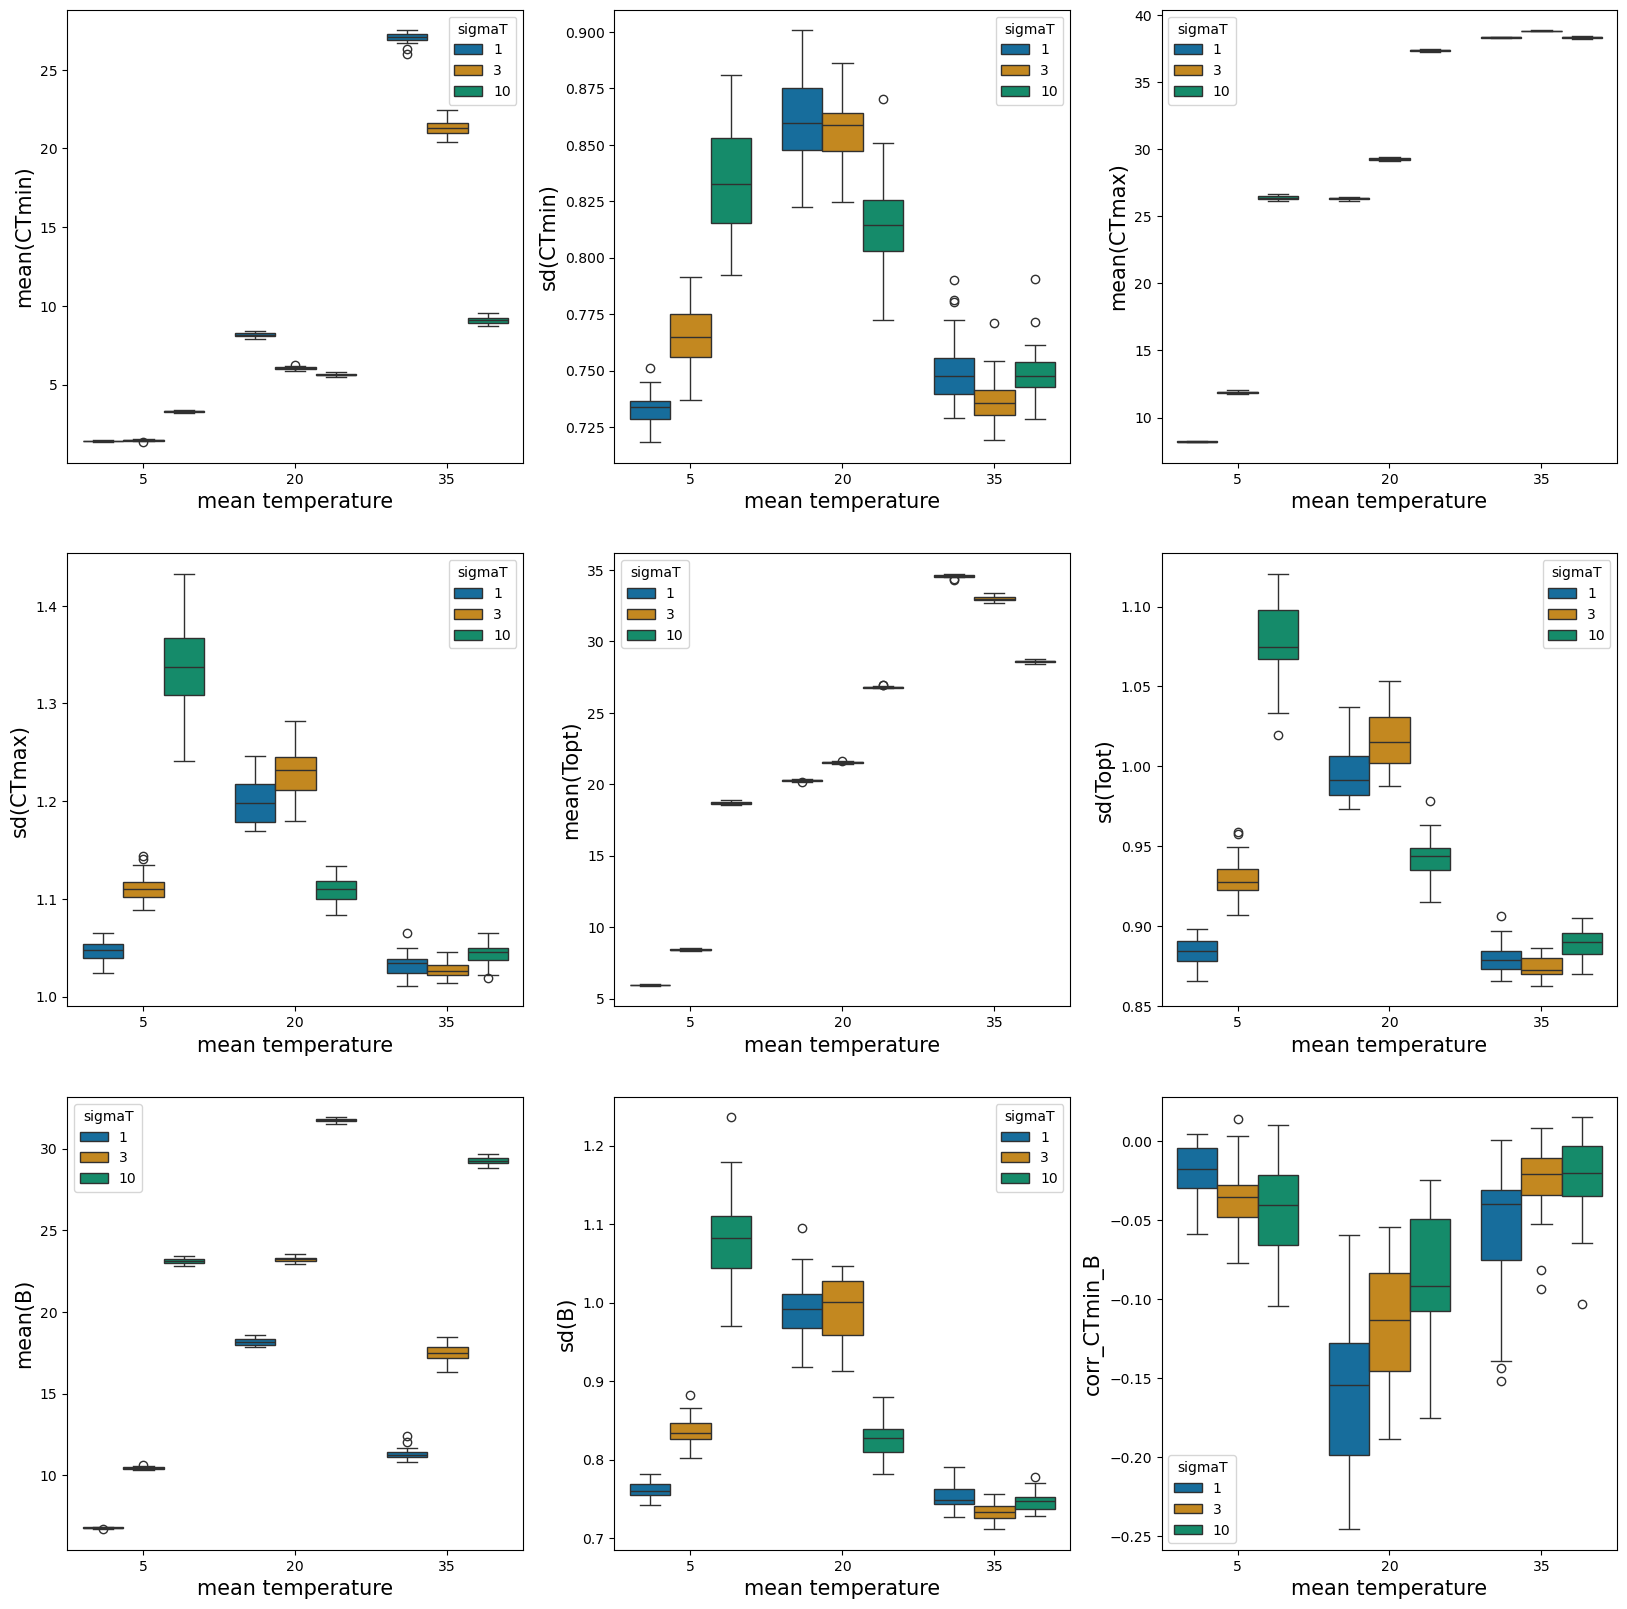

In [20]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20,20))
for i, key in enumerate(df.keys()[2:]):
    sns.boxplot(ax=ax.flat[i],
                x="muT",
                y=f"{key}",
                hue="sigmaT",
                palette=sns.color_palette('colorblind', 3), 
                data=df)
    ax.flat[i].set_ylabel(f"{key}", fontsize=15)
    ax.flat[i].set_xlabel("mean temperature", fontsize=15)
fig.savefig(f"{datadir}result-s1-boxplots.png")
fig.savefig(f"{datadir}result-s1-boxplots.pdf", bbox_inches='tight')

## Supplememtary to 2 - Alternative initial state: B = 5, CTmin = 33 (i.e. heat-specialist)

In some cases, it was not possible to find the trajectory from initial state to the equilibrium B and CTmin because the gradient is too shallow at the beginning, and it waas predicted that the population will stay there indefinitely. However, in simulation, the drift and mutation makes the population explore the (B, CTmin) explore even without much selection, and eventually, it reaches the part where gradient is strong enough so that the population searches the path to the optimal B and CTmin. Theoretical optima (red stars) were still found in all cases independently from searching B and CTmin maximizing the expected fitness. 

muT=5, sigmaT=1
end of trajectory: 1000000000.0
end of trajectory: 33.0, 5.0
muT=5, sigmaT=3
end of trajectory: 1000000000.0
end of trajectory: 32.999999999996675, 5.000000000000762
muT=5, sigmaT=10
end of trajectory: 1000000000.0
end of trajectory: 3.213774708102039, 23.03940590028729
muT=20, sigmaT=1
end of trajectory: 1000000000.0
end of trajectory: 33.0, 5.000000000000003
muT=20, sigmaT=3
end of trajectory: 1000000000.0
end of trajectory: 6.08772625917293, 22.823096704597795
muT=20, sigmaT=10
end of trajectory: 1000000000.0
end of trajectory: 5.8415301339947545, 32.932035416951415
muT=35, sigmaT=1
end of trajectory: 1000000000.0
end of trajectory: 26.418781993692914, 12.55590661466002
muT=35, sigmaT=3
end of trajectory: 1000000000.0
end of trajectory: 21.72590549028335, 17.706446486890528
muT=35, sigmaT=10
end of trajectory: 1000000000.0
end of trajectory: 9.113495691835285, 30.201044138816595


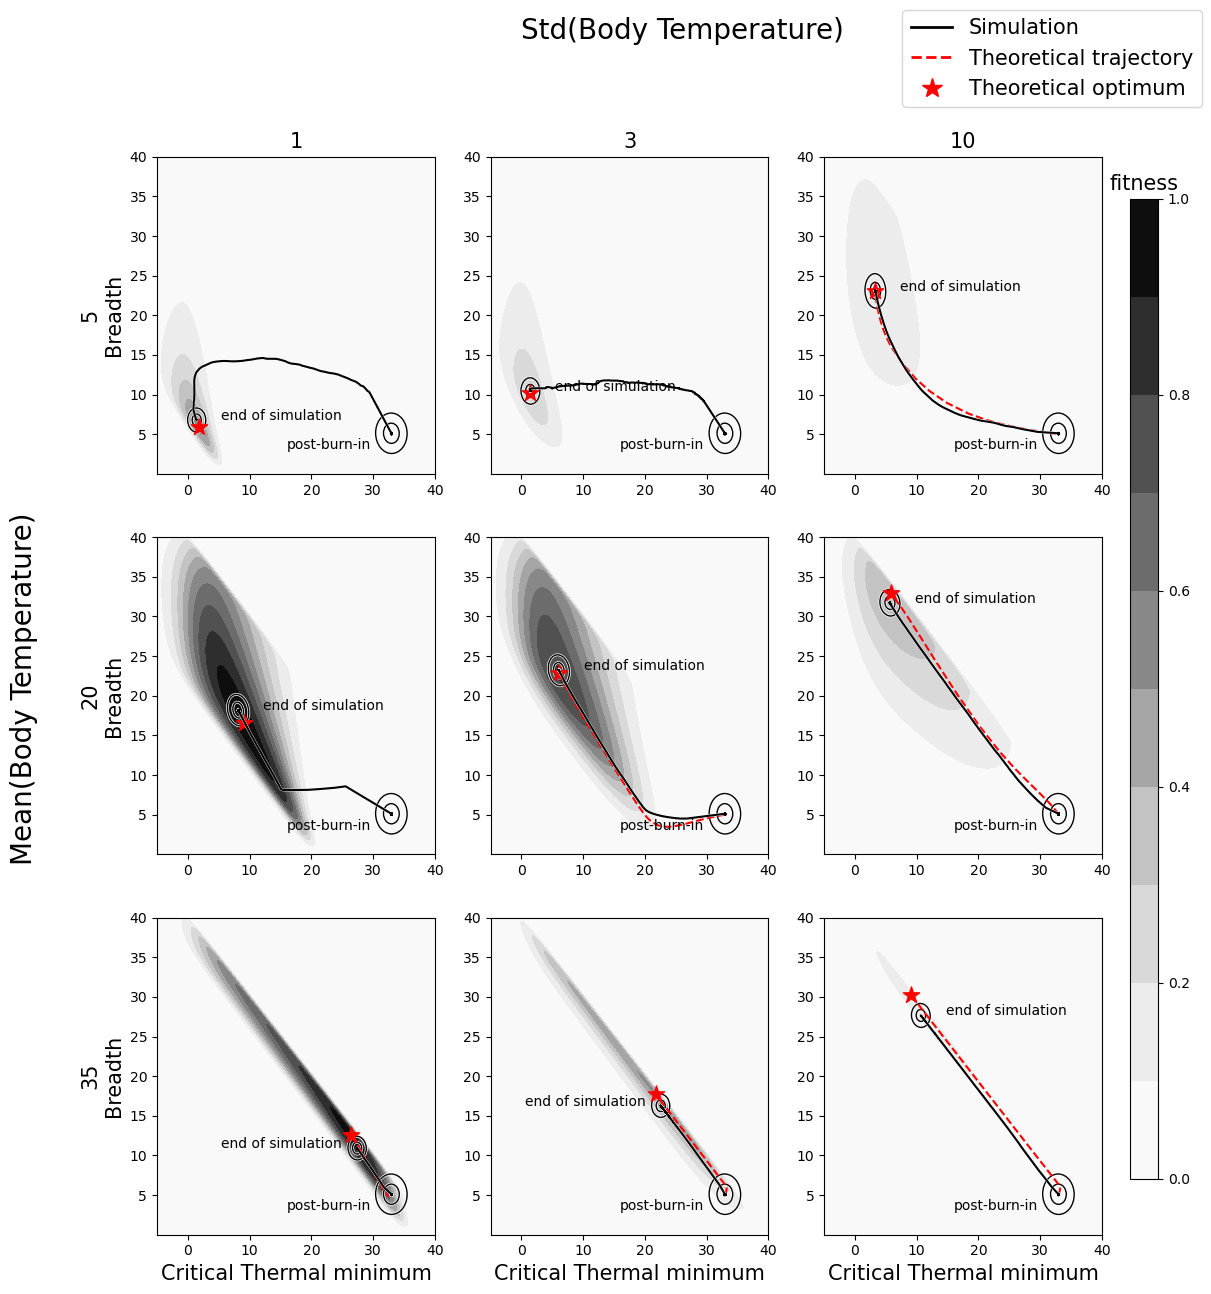

In [23]:
params_unique = pd.read_csv(f"{datadir}A1S1_nr_params_unique.csv")
muTs = params_unique.muT.unique()
sigmaTs = params_unique.sigmaT.unique()
# index for burn-in timing
t_0=500
fig, ax = plt.subplots(nrows = len(muTs), ncols = len(sigmaTs), figsize=(14, 14))       
# Store min and max cycle values for colorbar
all_cycle_values = []
contour_plot = None  # Store one contour plot for the colorbar
fig.supylabel("Mean(Body Temperature)", fontsize=20)
fig.suptitle("Std(Body Temperature)", fontsize=20)

for i, (muT, sigmaT) in enumerate(itertools.product(muTs, sigmaTs)):
    j = list(muTs).index(muT)
    k = list(sigmaTs).index(sigmaT)
    if sigmaT < 3:
        ax.flat[i].set_ylabel(f"{muT}\nBreadth", fontsize=15)
    if muT > 34:
        ax.flat[i].set_xlabel(f"Critical Thermal minimum", fontsize=15)
    elif muT < 10:
        ax.flat[i].set_title(f"{sigmaT}", fontsize=15)
    print(f"muT={muT}, sigmaT={sigmaT}")
    params_unique_subset = params_unique[params_unique.sigmaT > 0].reset_index()
    outname = params_unique_subset.loc[i, 'OUTNAME']
    avg_df = np.load(f"{datadir}avg_df_{outname}.npy", allow_pickle=True).item()
    analytical_info = np.load(f"{datadir}{outname}_analytical_info.npz", allow_pickle=True)
    
    contour = ax.flat[i].contourf(analytical_info['CTmin_grid'], 
                                  analytical_info['B_grid'], 
                                  analytical_info['W_contour'], 
                                  levels=np.linspace(0, 1, 11), 
                                  cmap='Greys')
    
    # Store the first contour plot for colorbar reference
    if contour_plot is None:
        contour_plot = contour
    
    ax.flat[i].plot(analytical_info['sol'].item().y[0], analytical_info['sol'].item().y[1], linestyle='--', color='r')
    print(f"end of trajectory: {analytical_info['sol'].item().t[-1]}") 

    print(f"end of trajectory: {analytical_info['sol'].item().y[0][-1]}, {analytical_info['sol'].item().y[1][-1]}") 
    # plot confidence ellipse for right after burnin period

    confidence_ellipse(avg_df['sd(CTmin)'][t_0], 
                       avg_df['sd(B)'][t_0], 
                       avg_df['cov(B, CTmin)'][t_0], 
                       avg_df['mean(CTmin)'][t_0], 
                       avg_df['mean(B)'][t_0],
                       ax.flat[i], 
                       n_std=1.0, 
                       edgecolor='white',
                       linewidth = 2
                      )
    confidence_ellipse(avg_df['sd(CTmin)'][t_0], 
                       avg_df['sd(B)'][t_0], 
                       avg_df['cov(B, CTmin)'][t_0], 
                       avg_df['mean(CTmin)'][t_0], 
                       avg_df['mean(B)'][t_0],
                       ax.flat[i], 
                       n_std=2.0, 
                       edgecolor='white',
                       linewidth=2
                      )

    confidence_ellipse(avg_df['sd(CTmin)'][t_0], 
                       avg_df['sd(B)'][t_0], 
                       avg_df['cov(B, CTmin)'][t_0], 
                       avg_df['mean(CTmin)'][t_0], 
                       avg_df['mean(B)'][t_0],
                       ax.flat[i], 
                       n_std=1.0, 
                       edgecolor='black', 
                      )
    confidence_ellipse(avg_df['sd(CTmin)'][t_0], 
                       avg_df['sd(B)'][t_0], 
                       avg_df['cov(B, CTmin)'][t_0], 
                       avg_df['mean(CTmin)'][t_0], 
                       avg_df['mean(B)'][t_0],
                       ax.flat[i], 
                       n_std=2.0, 
                       edgecolor='black', 
                      )
    # plot confidence ellipse at the end
    confidence_ellipse(avg_df['sd(CTmin)'][-1], 
                       avg_df['sd(B)'][-1], 
                       avg_df['cov(B, CTmin)'][-1], 
                       avg_df['mean(CTmin)'][-1], 
                       avg_df['mean(B)'][-1],
                       ax.flat[i], 
                       n_std=1.0, 
                       edgecolor='white',
                       linewidth=2
                      )
    confidence_ellipse(avg_df['sd(CTmin)'][-1], 
                       avg_df['sd(B)'][-1], 
                       avg_df['cov(B, CTmin)'][-1], 
                       avg_df['mean(CTmin)'][-1], 
                       avg_df['mean(B)'][-1],
                       ax.flat[i], 
                       n_std=2.0, 
                       edgecolor='white', 
                       linewidth=2
                      )

    
    # plot confidence ellipse at the end
    confidence_ellipse(avg_df['sd(CTmin)'][-1], 
                       avg_df['sd(B)'][-1], 
                       avg_df['cov(B, CTmin)'][-1], 
                       avg_df['mean(CTmin)'][-1], 
                       avg_df['mean(B)'][-1],
                       ax.flat[i], 
                       n_std=1.0, 
                       edgecolor='k', 
                      )
    confidence_ellipse(avg_df['sd(CTmin)'][-1], 
                       avg_df['sd(B)'][-1], 
                       avg_df['cov(B, CTmin)'][-1], 
                       avg_df['mean(CTmin)'][-1], 
                       avg_df['mean(B)'][-1],
                       ax.flat[i], 
                       n_std=2.0, 
                       edgecolor='k', 
                      )
    ax.flat[i].plot(avg_df['mean(CTmin)'], avg_df['mean(B)'], color = 'w', linewidth=2)
    ax.flat[i].plot(avg_df['mean(CTmin)'], avg_df['mean(B)'], color = 'k')
    ax.flat[i].scatter(analytical_info['CTmin_opt'], analytical_info['B_opt'], color='r', marker='*', s=150)
    if (j == 2) and (k < 2):
        x = avg_df['mean(CTmin)'][-1] - 22
    else:
        x = avg_df['mean(CTmin)'][-1]+4
    y = avg_df['mean(B)'][-1]
    ax[j, k].text(x,y, "end of simulation", 
                  color = 'k')
    ax[j, k].text(avg_df['mean(CTmin)'][t_0]-17, avg_df['mean(B)'][t_0]-2, 
                  f"post-burn-in", 
                  color = 'k')


# Adjust layout to make room for colorbars
fig.subplots_adjust(right=0.8)

# Add colorbar for the contour (fitness) - grayscale
cbar1_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar1 = fig.colorbar(contour_plot, cax=cbar1_ax)
fig.axes[-1].set_title('fitness', fontsize=15)


# Create custom legend handles
legend_handles = [
    Line2D([0], [0], color='k', linewidth=2, label='Simulation'),
    
    # Red dashed line for theoretical trajectory
    Line2D([0], [0], color='r', linestyle='--', linewidth=2, 
           label='Theoretical trajectory'),
    
    # Red star for theoretical optimum
    Line2D([0], [0], marker='*', color='w', markerfacecolor='r', 
           markeredgecolor='r', markersize=15, linestyle='None',
           label='Theoretical optimum'),
]

# Add the legend to the figure (outside the subplots)
fig.legend(handles=legend_handles, 
          loc='center left',  # or 'upper left', 'lower left', etc.
          bbox_to_anchor=(0.65, 0.95),  # Adjust position (x, y)
          fontsize=15)


fig.savefig(f"{datadir}result-s1-landscape-alt-initial.png")
fig.savefig(f"{datadir}result-s1-landscape-alt-initial.pdf", bbox_inches='tight')

## Discussion / Supplementary - How strong is generalist-specialist tradeoff in our simulated TPCs?

Typically, people define the tradeoff as a negative slope between height and width of TPCs. It is a little unclear whether each data point should be from a single individual or can represent a population, or whether the points in one plot should be from a single population or can be pulled from various replicate experiments/simulations or even from different experimental conditions. To be safe, I perform linear regression using individuals from a single replicate simulation, sampled at the same time (end of simulation). 


In [7]:
# Regress w_TPC(Topt) and B in each simulation
def regress_height_and_width(row):
    ts = tskit.load(f"{datadir}{row.OUTNAME}.trees")
    metadata = ts.metadata['SLiM']['user_metadata']
    Bs = np.array(metadata['Bs_final'])
    CTmins = np.array(metadata['CTmins_final'])
    Topts = CTmins + Bs * 2/3
    CTmaxs = CTmins + Bs
    heights = [tpc_object.w_TPC(CTmin=CTmin, B=B, T=Topt) for CTmin,B,Topt in zip(CTmins, Bs, Topts)]
    slope, intercept, r, p, se = scipy.stats.linregress(Bs, scipy.special.logit(heights))
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    scatter = ax.scatter(Bs, scipy.special.logit(heights), c=CTmaxs, cmap='viridis', vmin=5, vmax=41)
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('CTmax')
    ax.set_xlabel("Breadth ($B$)")
    ax.set_ylabel("logit(Height) ($logit[w_{TPC}(Topt)]$)")
    xlims = (3,35)
    x = np.linspace(*xlims, 100)
    regression_line_y = slope * x + intercept
    ax.plot(x, regression_line_y, label=f"slope={slope:.3f}, p={p}")
    ax.set_ylim((-10, 15))
    ax.set_xlim(xlims)
    ax.set_title(f"{row.OUTNAME}")
    fig.savefig(f"{datadir}height_width_regress{row.OUTNAME}.png")
    plt.close()
    return (row.muT, row.sigmaT, slope, r, p)

height_width_regress_df = params.apply(regress_height_and_width, axis=1, result_type='expand')
height_width_regress_df.columns = ['mean(T)', 'std(T)', 'slope', 'r', 'p']

Get the mean and standard deviation of slopes for each temperature distribution, only using those with p < 0.05. Also count the number of slopes that had p < 0.05. The mean slope is negative in all conditions, but quite a few simulations failed to reject null hypothesis of zero slope when mean temperature is 5. Especially when mean is 5 and standard deviation is 1, majority of the times there is no significant negative correlation between height and width of TPC. 

In [8]:
height_width_regress_df[height_width_regress_df.p < 0.05].groupby(['mean(T)', 'std(T)']).agg({
    'slope': ['mean', 'std', 'count']})

slope                
                    mean       std count
mean(T) std(T)                          
5.0     1.0    -0.021231  0.004197     8
        3.0    -0.021029  0.006044    22
        10.0   -0.024252  0.008648    21
20.0    1.0    -0.070112  0.020206    30
        3.0    -0.053049  0.017253    30
        10.0   -0.320668  0.023310    30
35.0    1.0    -3.850524  0.164970    30
        3.0    -3.848738  0.091937    30
        10.0   -1.251244  0.072454    30

## Discussion / Supplementary : Testing "Hotter is Better" Hypothesis

Countering "jack-of-all-temperatures is master of none", there is another hypothesis called "hotter is better" (Huey and Kingsolver 1989). Quantitatively, "hotter is better" implies positive correlation between height of TPC ($w_{TPC}(Topt)$) and the thermal optimum ($Topt$). So I do similar logistic regression as before, this time between height and thermal optimum. There is a pretty strong correlation for TPCs for those that have CTmax less than about 38. (see scatter plots with mean(T) = 20, std(T) = 10, for instance) The TPCs with high CTmax, there is a sharp decline in height as thermal optimum increases.

In [9]:
# Regress w_TPC(Topt) and B in each simulation
def regress_height_and_Topt(row):
    ts = tskit.load(f"{datadir}{row.OUTNAME}.trees")
    metadata = ts.metadata['SLiM']['user_metadata']
    Bs = np.array(metadata['Bs_final'])
    CTmins = np.array(metadata['CTmins_final'])
    Topts = CTmins + Bs * 2/3
    CTmaxs = CTmins + Bs
    heights = [tpc_object.w_TPC(CTmin=CTmin, B=B, T=Topt) for CTmin,B,Topt in zip(CTmins, Bs, Topts)]
    slope, intercept, r, p, se = scipy.stats.linregress(Topts, scipy.special.logit(heights))
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    scatter = ax.scatter(Topts, scipy.special.logit(heights), c=CTmaxs, cmap='viridis', vmin=5, vmax=41)
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('CTmax')
    ax.set_xlabel("Thermal optimum ($Topt$)")
    ax.set_ylabel("logit(Height) ($logit[w_{TPC}(Topt)]$)")
    xlims = (3,39)
    x = np.linspace(*xlims, 100)
    regression_line_y = slope * x + intercept
    ax.plot(x, regression_line_y, label=f"slope={slope:.3f}, p={p}")
    ax.set_ylim((-10, 15))
    ax.set_xlim(xlims)
    ax.set_title(f"{row.OUTNAME}")
    fig.savefig(f"{datadir}height_Topt_regress{row.OUTNAME}.png")
    plt.close()
    return (row.muT, row.sigmaT, slope, r, p)

height_topt_regress_df = params.apply(regress_height_and_Topt, axis=1, result_type='expand')
height_topt_regress_df.columns = ['mean(T)', 'std(T)', 'slope', 'r', 'p']

In [10]:
height_topt_regress_df[height_topt_regress_df.p < 0.05].groupby(['mean(T)', 'std(T)']).agg({
    'slope': ['mean', 'std', 'count']})

slope                
                    mean       std count
mean(T) std(T)                          
5.0     1.0     0.339520  0.004117    30
        3.0     0.329278  0.007225    30
        10.0    0.286892  0.014916    30
20.0    1.0     0.325761  0.009574    30
        3.0     0.318473  0.010036    30
        10.0   -0.009960  0.038766    18
35.0    1.0    -4.613491  0.044774    30
        3.0    -4.467035  0.074718    30
        10.0   -1.191437  0.077496    30

In [ ]:
# Regress w_TPC(Topt) and B in each simulation
def regress_height_and_Topt(row):
    ts = tskit.load(f"{datadir}{row.OUTNAME}.trees")
    metadata = ts.metadata['SLiM']['user_metadata']
    Bs = np.array(metadata['Bs_final'])
    CTmins = np.array(metadata['CTmins_final'])
    Topts = CTmins + Bs * 2/3
    CTmaxs = CTmins + Bs
    heights = [tpc_object.w_TPC(CTmin=CTmin, B=B, T=Topt) for CTmin,B,Topt in zip(CTmins, Bs, Topts)]
    slope, intercept, r, p, se = scipy.stats.linregress(Topts, scipy.special.logit(heights))
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    scatter = ax.scatter(Topts, scipy.special.logit(heights), c=CTmaxs, cmap='viridis', vmin=5, vmax=41)
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('CTmax')
    ax.set_xlabel("Thermal optimum ($Topt$)")
    ax.set_ylabel("logit(Height) ($logit[w_{TPC}(Topt)]$)")
    xlims = (3,39)
    x = np.linspace(*xlims, 100)
    regression_line_y = slope * x + intercept
    ax.plot(x, regression_line_y, label=f"slope={slope:.3f}, p={p}")
    ax.set_ylim((-10, 15))
    ax.set_xlim(xlims)
    ax.set_title(f"{row.OUTNAME}")
    fig.savefig(f"{datadir}height_Topt_regress{row.OUTNAME}.png")
    plt.close()
    return (row.muT, row.sigmaT, slope, r, p)

height_topt_regress_df = params.apply(regress_height_and_Topt, axis=1, result_type='expand')
height_topt_regress_df.columns = ['mean(T)', 'std(T)', 'slope', 'r', 'p']

Put them into 3 X 3 grid. Each plot only use one simulation with random seed = 29. (Same simulation used for sample TPC graph)

In [5]:
params_29 = params[params.seed==29]
params_29 = params_29.sort_values(by=['muT', 'sigmaT']).reset_index(drop=True)

In [6]:
params_29

,run_id,muT,sigmaT,seed,N,RUNTIME,B_WT,CTmin_WT,OUTNAME
0,29,5,1,29,5000,20000,31,5,A1_nr_muT_5_sigmaT_1_seed_29
1,59,5,3,29,5000,20000,31,5,A1_nr_muT_5_sigmaT_3_seed_29
2,89,5,10,29,5000,20000,31,5,A1_nr_muT_5_sigmaT_10_seed_29
3,119,20,1,29,5000,20000,31,5,A1_nr_muT_20_sigmaT_1_seed_29
4,149,20,3,29,5000,20000,31,5,A1_nr_muT_20_sigmaT_3_seed_29
5,179,20,10,29,5000,20000,31,5,A1_nr_muT_20_sigmaT_10_seed_29
6,209,35,1,29,5000,20000,31,5,A1_nr_muT_35_sigmaT_1_seed_29
7,239,35,3,29,5000,40000,31,5,A1_nr_muT_35_sigmaT_3_seed_29
8,269,35,10,29,5000,20000,31,5,A1_nr_muT_35_sigmaT_10_seed_29


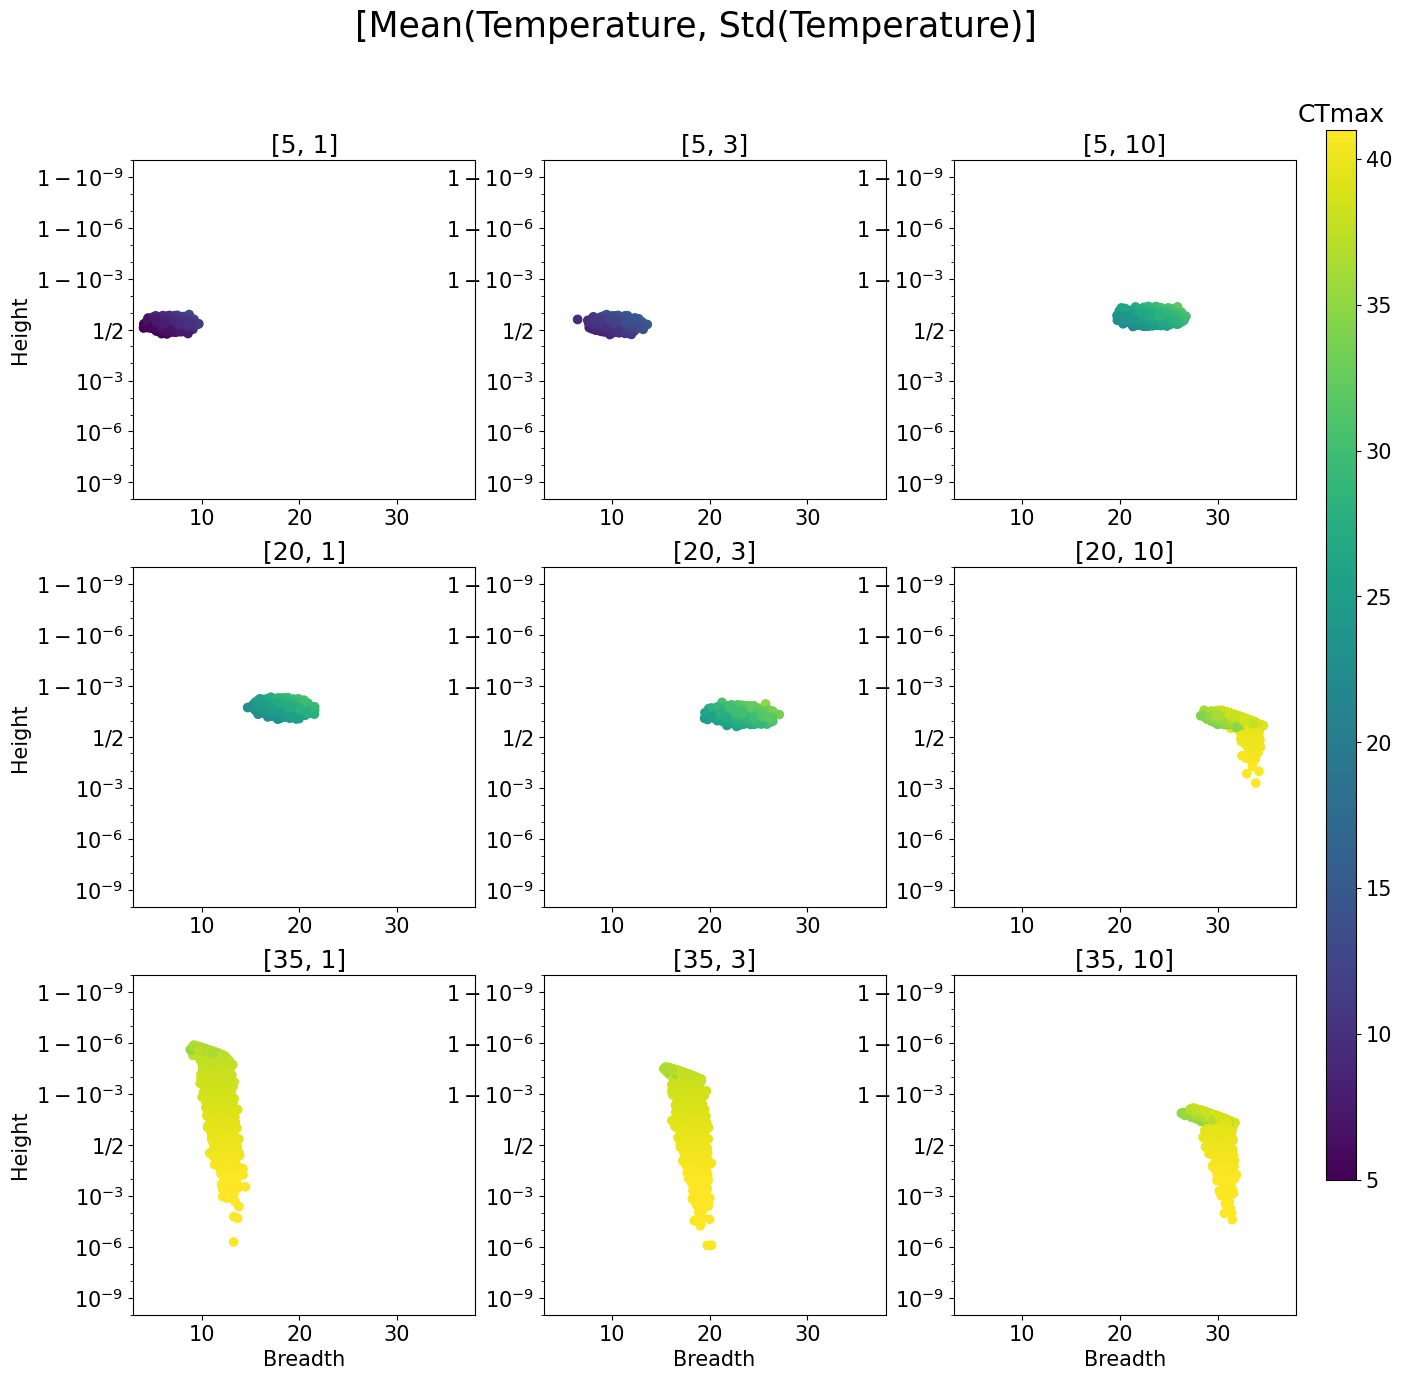

In [7]:
# Plot w_TPC(Topt) and B for only seed = 29
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,15))
def regress_height_and_width(row):
    ts = tskit.load(f"{datadir}{row.OUTNAME}.trees")
    metadata = ts.metadata['SLiM']['user_metadata']
    Bs = np.array(metadata['Bs_final'])
    CTmins = np.array(metadata['CTmins_final'])
    Topts = CTmins + Bs * 2/3
    CTmaxs = CTmins + Bs
    heights = [tpc_object.w_TPC(CTmin=CTmin, B=B, T=Topt) for CTmin,B,Topt in zip(CTmins, Bs, Topts)]
    scatter = ax.flat[row.name].scatter(Bs, heights, c=CTmaxs, cmap='viridis', vmin=5, vmax=41)
    ax.flat[row.name].set_title(f"[{row.muT}, {row.sigmaT}]")
    if row.muT == 35:
        ax.flat[row.name].set_xlabel("Breadth")
    if row.sigmaT == 1:
        ax.flat[row.name].set_ylabel("Height")
    ax.flat[row.name].set_yscale("logit", one_half="1/2")
    xlims = (3,38)
    ax.flat[row.name].set_ylim((1e-10, 1-1e-10))
    ax.flat[row.name].set_xlim(xlims)    
    return scatter
fig.suptitle("[Mean(Temperature, Std(Temperature)]", fontsize=25)
scatter = params_29.apply(regress_height_and_width, axis=1, result_type='expand')
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.7])  # [left, bottom, width, height]

fig.colorbar(cm.ScalarMappable(norm=mpl.colors.Normalize(5, 41), cmap='viridis'),
             cax=cbar_ax, orientation='vertical')
cbar_ax.set_title("CTmax")
fig.savefig(f"{datadir}results-generalist-specialist-tradeoff.pdf", bbox_inches='tight')


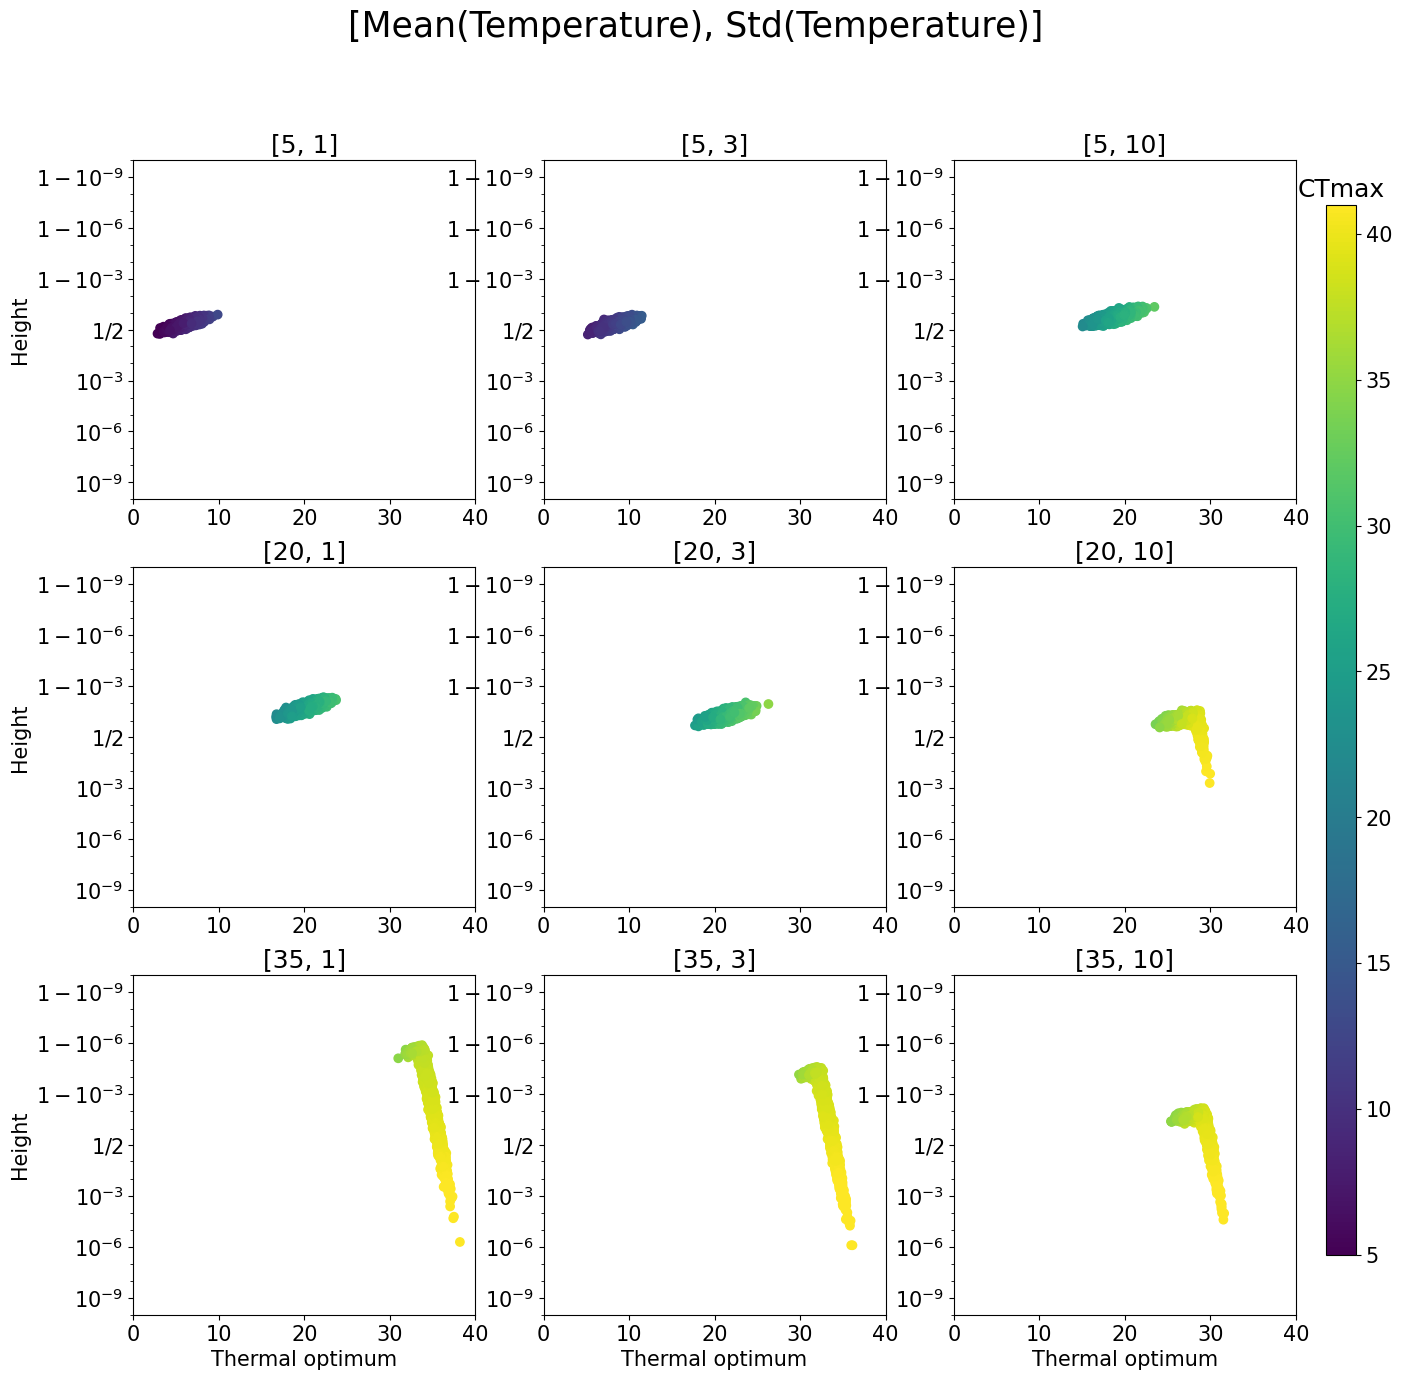

In [8]:
# Plot w_TPC(Topt) and Topt for only seed = 29
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,15))
def regress_height_and_Topt(row):
    ts = tskit.load(f"{datadir}{row.OUTNAME}.trees")
    metadata = ts.metadata['SLiM']['user_metadata']
    Bs = np.array(metadata['Bs_final'])
    CTmins = np.array(metadata['CTmins_final'])
    Topts = CTmins + Bs * 2/3
    CTmaxs = CTmins + Bs
    heights = [tpc_object.w_TPC(CTmin=CTmin, B=B, T=Topt) for CTmin,B,Topt in zip(CTmins, Bs, Topts)]
    scatter = ax.flat[row.name].scatter(Topts, heights, c=CTmaxs, cmap='viridis', vmin=5, vmax=41)
    ax.flat[row.name].set_title(f"[{row.muT}, {row.sigmaT}]")
    if row.muT == 35:
        ax.flat[row.name].set_xlabel("Thermal optimum")
    if row.sigmaT == 1:
        ax.flat[row.name].set_ylabel("Height")
    ax.flat[row.name].set_yscale("logit", one_half="1/2")
    xlims = (0,40)
    ax.flat[row.name].set_ylim((1e-10, 1-1e-10))
    ax.flat[row.name].set_xlim(xlims)    
    return scatter
fig.suptitle("[Mean(Temperature), Std(Temperature)]", fontsize=25)
scatter = params_29.apply(regress_height_and_Topt, axis=1, result_type='expand')
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(cm.ScalarMappable(norm=mpl.colors.Normalize(5, 41), cmap='viridis'),
             cax=cbar_ax, orientation='vertical')
cbar_ax.set_title("CTmax")
fig.savefig(f"{datadir}result-hotter-is-better.pdf", bbox_inches='tight')

In [85]:
def QTN_stats(row):
    '''
    Find the number of segregating QTN's mutations at the end of the simulation and the mean and standard deviation of effect sizes
    '''
    ts = tskit.load(f"{datadir}{row.OUTNAME}.trees")
    QTN_Bs = []
    QTN_CTmins = []
    for mut in ts.mutations():
        for submut in mut.metadata['mutation_list']:
            if submut['mutation_type'] == 2:
                QTN_Bs.append(submut['selection_coeff'])
            else:
                QTN_CTmins.append(submut['selection_coeff'])
    return (row.muT, row.sigmaT, len(QTN_Bs), np.mean(QTN_Bs), np.std(QTN_Bs), len(QTN_CTmins), np.mean(QTN_CTmins), np.std(QTN_CTmins))
QTN_df = params_29.apply(QTN_stats, axis=1, result_type='expand')
QTN_df.columns = ['mean(T)', 'sd(T)', 'num_QTN_Bs', 'mean(QTN_B_effect_size)', 'std(QTN_B_effect_size)', 'num_QTN_CTmins', 'mean(QTN_CTmin_effect_size)', 'std(QTN_CTmin_effect_size)']
QTN_df['mean(T)'] = QTN_df['mean(T)'].astype(int)
QTN_df['sd(T)'] = QTN_df['sd(T)'].astype(int)
QTN_df['num_QTN_Bs'] = QTN_df['num_QTN_Bs'].astype(int)
QTN_df['num_QTN_CTmins'] = QTN_df['num_QTN_CTmins'].astype(int)
print(QTN_df.to_latex(index=False))

\begin{tabular}{rrrrrrrr}
\toprule
mean(T) & sd(T) & num_QTN_Bs & mean(QTN_B_effect_size) & std(QTN_B_effect_size) & num_QTN_CTmins & mean(QTN_CTmin_effect_size) & std(QTN_CTmin_effect_size) \\
\midrule
5 & 1 & 366 & -0.017840 & 0.209674 & 344 & 0.004788 & 0.182606 \\
5 & 3 & 411 & -0.021949 & 0.220067 & 389 & 0.007820 & 0.190730 \\
5 & 10 & 431 & -0.020339 & 0.218062 & 377 & -0.002107 & 0.201675 \\
20 & 1 & 512 & -0.011141 & 0.205708 & 441 & 0.012994 & 0.205867 \\
20 & 3 & 535 & -0.003098 & 0.211783 & 472 & 0.007181 & 0.194784 \\
20 & 10 & 379 & -0.023875 & 0.193405 & 421 & 0.002649 & 0.175866 \\
35 & 1 & 361 & -0.030586 & 0.182576 & 384 & 0.043685 & 0.185895 \\
35 & 3 & 286 & -0.017332 & 0.163488 & 311 & 0.018032 & 0.197787 \\
35 & 10 & 191 & -0.010259 & 0.189502 & 191 & 0.018297 & 0.185907 \\
\bottomrule
\end{tabular}

